# Tiny Imagenet (Part II)

> Scaling up the dataset and training a UNet model

Adapted from

- [https://youtu.be/z1In7QaG0fg?si=U_umYKYz2E_ODGzC&t=2714](https://youtu.be/z1In7QaG0fg?si=U_umYKYz2E_ODGzC&t=2714)

In [1]:
#| default_exp tinyimagenet_b

In [ ]:
# |export
import torch
from torch import nn

from slowai.augmentation import summarize
from slowai.ddpm import MixedPrecision
from slowai.initializations import init_leaky_weights
from slowai.resnets import Conv, GeneralReLU, ResidualConvBlock
from slowai.tinyimagenet_a import (
    StackableResidualConvBlock,
    get_imagenet_dls as get_imagenet_dls_classification,
    lr_find,
    preprocess_and_trivial_augment,
    train,
)

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dls = get_imagenet_dls(bs=512, training_preprocessor=preprocess_and_trivial_augment)

### Improvements to the ResBlock

Consider the implementation of the ResBlock.

In [4]:
ResidualConvBlock??

Init signature: ResidualConvBlock(c_in, c_out, stride=2, ks=3, act=True, norm=True)
Source:        
class ResidualConvBlock(nn.Module):
    """Convolutional block with residual links"""

    def __init__(self, c_in, c_out, stride=2, ks=3, act=True, norm=True):
        super().__init__()
        self.conv_a = Conv(c_in, c_out, stride=1, ks=ks, act=act, norm=norm)
        self.conv_b = Conv(c_out, c_out, stride=stride, ks=ks, act=False, norm=norm)
        self.id_conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=1)
        self.act = GeneralReLU() if act else None

    def forward(self, x):
        x_orig = x.clone()
        # Downsample the original, if neccesary
        if self.conv_b.stride == (2, 2):
            x_orig = F.avg_pool2d(x_orig, kernel_size=2, ceil_mode=True)
        elif self.conv_b.stride[0] > 2 or self.conv_b.stride[1] > 2:
            raise ValueError
        else:
            assert self.conv_b.stride == (1, 1)
        # Add extra channels, if neccesary
        if

Notice that the original logits are passed through the activation function. There is no "pure" identity path.

```python
x += x_orig
if self.act:
    x = self.act(x)
return x
```

This was pointed out in the "Identity Mappings in Deep Residual Networks" paper by the original author of the ResNet paper. This is called a **pre-activation resblock**.

![preactivation conv diagram](media/preactivation_conv_diagram.jpg)

In [5]:
class PreactivationConv(nn.Module):
    def __init__(self, c_in, c_out, stride=2, ks=3):
        super().__init__()
        self.norm = nn.BatchNorm2d(c_in)
        self.act = GeneralReLU()
        self.conv = nn.Conv2d(
            c_in,
            c_out,
            stride=stride,
            kernel_size=ks,
            padding=ks // 2,
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

In [6]:
class PreactivationResidualConv(nn.Module):
    """Convolutional block with residual links"""

    def __init__(self, c_in, c_out, stride=2, ks=3):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.stride = stride
        self.conv_a = PreactivationConv(c_in, c_out, stride=1, ks=ks)
        self.conv_b = PreactivationConv(c_out, c_out, stride=stride, ks=ks)
        self.id_conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=1)
        self.pool = nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        # residual path
        xr = x.clone()
        if self.stride == 1:
            pass
        elif self.stride == 2:
            xr = self.pool(xr)
        else:
            raise ValueError("Only 2x downsampling supported")
        if self.c_in != self.c_out:
            xr = self.id_conv(xr)

        # non-residual path
        x = self.conv_a(x)
        x = self.conv_b(x)

        return xr + x

In [7]:
class TinyImagePreactivationResNet(nn.Module):
    def __init__(
        self,
        nfs,
        n_blocks,
        n_outputs=10,
        p_drop=0.1,
    ):
        super().__init__()

        # Note that we __cannot__ start with a pre-activation
        # resblock because it starts with a non-linearity!
        # Doing so would throw away half the data
        layers = [Conv(3, nfs[0], ks=5, stride=1)]
        for nb, c_in, c_out in zip(n_blocks, nfs, nfs[1:]):
            block = StackableResidualConvBlock(
                nb,
                c_in,
                c_out,
                conv_cls=PreactivationResidualConv,
            )
            layers.append(block)
        self.layers = nn.Sequential(*layers)

        self.conv_act = GeneralReLU()
        self.conv_norm = nn.BatchNorm2d(nfs[-1])
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(p_drop)
        self.lin = nn.Linear(nfs[-1], n_outputs, bias=False)
        self.lin_norm = nn.BatchNorm1d(n_outputs)

    def forward(self, x):
        x = self.layers(x)
        # Since the identity path has no ReLu, we need to
        # perform a non-linearity and normalization at the
        # end of the conv block stack
        x = self.conv_act(x)
        x = self.conv_norm(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.drop(x)
        x = self.lin(x)
        x = self.lin_norm(x)
        return x

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

In [8]:
def get_model():
    n_blocks = (3, 2, 2, 1, 1)
    return TinyImagePreactivationResNet.kaiming(
        n_outputs=200,
        nfs=[32, 64, 128, 256, 512, 1024],
        n_blocks=(3, 2, 2, 1, 1),
    )

In [9]:
model = get_model()
mods = [*model.layers, model.conv_norm, model.lin, model.lin_norm]
summarize(model, mods, dls)

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (512, 3, 64, 64) | (512, 32, 64, 64) | 2,464 | 9.8
| StackableResidualConvBlock | (512, 32, 64, 64) | (512, 64, 32, 32) | 214,272 | 218.1
| StackableResidualConvBlock | (512, 64, 32, 32) | (512, 128, 16, 16) | 542,336 | 138.4
| StackableResidualConvBlock | (512, 128, 16, 16) | (512, 256, 8, 8) | 2,166,016 | 138.4
| StackableResidualConvBlock | (512, 256, 8, 8) | (512, 512, 4, 4) | 3,673,088 | 58.7
| StackableResidualConvBlock | (512, 512, 4, 4) | (512, 1024, 2, 2) | 14,686,208 | 58.7
| BatchNorm2d | (512, 1024, 2, 2) | (512, 1024, 2, 2) | 2,048 | 0.0
| Linear | (512, 1024) | (512, 200) | 204,800 | 0.2
| BatchNorm1d | (512, 200) | (512, 200) | 400 | 0.0
| Total | | | 21,491,632 | 622.4215839999999 |

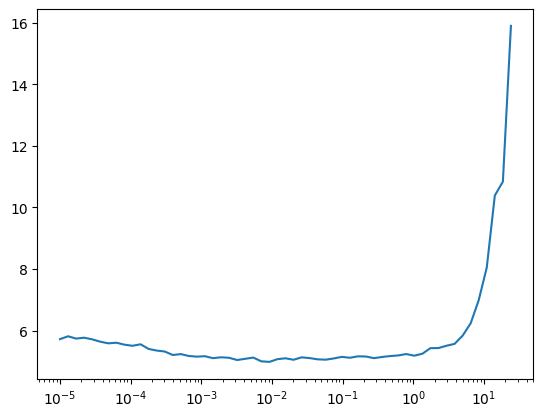

In [10]:
lr_find(model, dls, start_lr=1e-5, extra_cbs=[])

MulticlassAccuracy,loss,epoch,train
0.041,4.908,0,train
0.065,4.602,0,eval
0.067,4.606,1,train
0.073,4.447,1,eval
0.084,4.434,2,train
0.044,5.870,2,eval
0.096,4.323,3,train
0.087,4.546,3,eval
0.106,4.231,4,train
0.065,4.708,4,eval


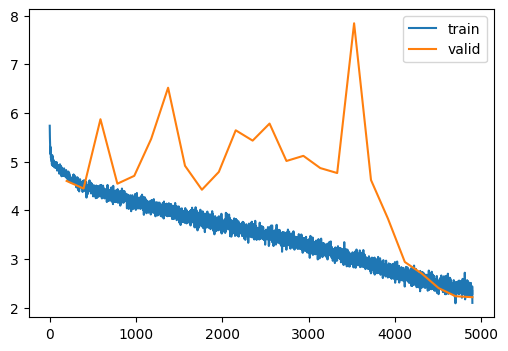

In [11]:
model = get_model()
train(model, dls, lr=0.1, n_epochs=25, extra_cbs=[])

Considerably worse. I wonder why.

In [12]:
#| hide
import nbdev

nbdev.nbdev_export()